In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from splot.mapping import vba_choropleth, vba_legend, mapclassify_bin
from shapely.geometry import Point, Polygon, LineString
import libpysal.weights as sw 
from esda.moran import Moran_Local, Moran
from splot.esda import lisa_cluster, plot_local_autocorrelation, plot_moran
import warnings
import census
import us
import rasterio
warnings.simplefilter("ignore") 

In [28]:
from rasterio.plot import show
import requests
import rasterstats as rstats

In [2]:
c = census.Census('bbf0f9cd4d3e9a9bb4c295578e2e6cb2765ced0d', year=2020)

In [23]:
#test
c.acs5.state(('NAME', 'B19013_001E'), us.states.MD.fips)

[{'NAME': 'Maryland', 'B19013_001E': 87063.0, 'state': '24'}]

In [29]:
#access census data
#variable names: total, white alone, black alone, asian alone, median household income
#consider ratio of income to poverty level? B17002
acs_list = c.acs5.state_county_tract(('NAME', 'B02001_001E','B02001_002E', 'B02001_002E', 'B02001_005E','B19013_001E'), us.states.NY.fips, '005', census.ALL)

In [26]:
nyc_acs = pd.DataFrame(acs_list)

In [37]:
codes={'manhattan':'061', 'staten_island':'085','bronx':'005', 'queens':'081', 'brooklyn':'047'}
list_of_lists=[]
for i in codes:
    acs_list = c.acs5.state_county_tract(('NAME', 'B02001_001E','B02001_002E', 'B02001_003E', 'B02001_005E','B19013_001E'), us.states.NY.fips, codes[i], census.ALL)
    list_of_lists.append(acs_list)
nyc_acs=pd.concat([pd.DataFrame(j) for j in list_of_lists])  

In [38]:
nyc_acs.columns=['name', 'total','white_alone', 'black_alone', 'asian_alone', 'med_income', 'state', 'county', 'tract']
nyc_acs['GEOID']=nyc_acs['state']+nyc_acs['county']+nyc_acs['tract']
nyc_acs['percent_white'] = 100* (nyc_acs['white_alone'].astype('int')/nyc_acs['total'].astype('int'))
nyc_acs['percent_black'] = 100* (nyc_acs['black_alone'].astype('int')/nyc_acs['total'].astype('int'))
nyc_acs['percent_asian'] = 100* (nyc_acs['asian_alone'].astype('int')/nyc_acs['total'].astype('int'))

In [39]:
nyc_acs.head()

,name,total,white_alone,black_alone,asian_alone,med_income,state,county,tract,GEOID,percent_white,percent_black,percent_asian
0,"Census Tract 165, New York County, New York",6674.0,5425.0,148.0,469.0,184691.0,36,061,016500,36061016500,81.285586,2.217561,7.027270
1,"Census Tract 166, New York County, New York",6002.0,2824.0,859.0,658.0,47778.0,36,061,016600,36061016600,47.050983,14.311896,10.963012
2,"Census Tract 167, New York County, New York",6058.0,5236.0,36.0,480.0,203711.0,36,061,016700,36061016700,86.431165,0.594256,7.923407
3,"Census Tract 168, New York County, New York",5189.0,1721.0,1915.0,355.0,27222.0,36,061,016800,36061016800,33.166313,36.904991,6.841395
4,"Census Tract 169, New York County, New York",8272.0,6895.0,113.0,537.0,131097.0,36,061,016900,36061016900,83.353482,1.366054,6.491779


***NDVI, NDWI

In [115]:
#from EO Browser, 16 bit, medium resolution
ndvi=rasterio.open('S:/376/Spring22/jkchap16/sentinel_9_19_21_ndvi.tiff')

In [116]:
parks=gpd.read_file('S:/376/Spring22/jkchap16/nyc_parks.zip')
parks = parks.to_crs(ndvi.crs.data)
parks=parks[(parks['landuse']=='Neighborhood Park') | (parks['landuse']=='Community Park') |(parks['landuse']=='Nature Area') |(parks['landuse']=='Garden') | (parks['landuse']=='Flagship Park')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

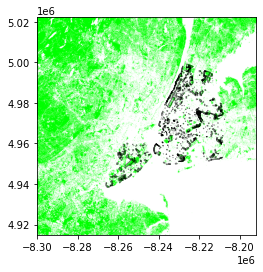

In [117]:
fig, ax = plt.subplots()
rasterio.plot.show(ndvi, cmap='RdYlGn', ax=ax)
parks.plot(ax=ax, facecolor='none', edgecolor='black', alpha=.5)

In [118]:
with rasterio.open('S:/376/Spring22/jkchap16/sentinel_9_19_21_ndvi.tiff') as src:
    ndvi = src.read(1, window= rasterio.windows.from_bounds(-8266069.89886961,  4938302.3518047 , -8204449.4381029 ,
        4999279.62331638, src.transform))
    affine=src.transform
    print(src.profile)
    


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2500, 'height': 1132, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(93.92582035682537, 0.0, -8376214.149582505,
       0.0, -93.99323619520308, 5010058.192399354), 'tiled': False, 'compress': 'deflate', 'interleave': 'pixel'}


Text(0, 0.5, 'Row #')

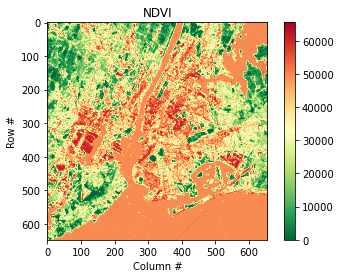

In [119]:
plt.imshow(ndvi, cmap='RdYlGn_r') 
plt.colorbar()
plt.title('NDVI')
plt.xlabel('Column #')
plt.ylabel('Row #')

In [120]:
parks_ndvi = rstats.zonal_stats(parks.geometry, ndvi, affine = affine)

In [121]:
avg = [r['mean'] for r in parks_ndvi]
parks['avg_ndvi'] = avg

<Figure size 720x720 with 0 Axes>

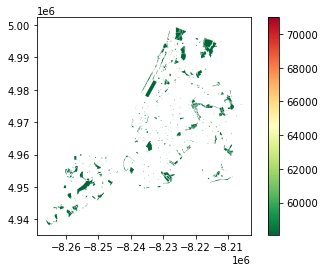

In [122]:
plt.figure(figsize=(10,10))
parks.plot('avg_ndvi', cmap='RdYlGn_r', legend=True)
plt.show()

In [123]:
parks

,feat_code,landuse,park_name,parknum,shape_area,shape_leng,source_id,status,sub_code,system,geometry,avg_ndvi
0,4910.0,Community Park,Commodore Barry Park,B021,4.153980e+04,829.420107,2.149100e+10,Updated,491050.0,None,"POLYGON ((-8235329.517 4967898.091, -8235332.6...",64537.0
1,4980.0,Neighborhood Park,Pierrepont Playground,B222,2.196049e+04,607.555193,2.149800e+10,Unchanged,498000.0,None,"POLYGON ((-8237344.014 4967605.736, -8237344.2...",64537.0
2,4980.0,Neighborhood Park,Cobble Hill Park,B326,2.807908e+04,784.421990,2.149800e+10,Unchanged,498000.0,None,"POLYGON ((-8237149.641 4966419.691, -8237149.6...",NaN
3,4980.0,Community Park,Commodore Barry Park,B021,4.384161e+05,2672.710150,2.149800e+10,Unchanged,498000.0,None,"POLYGON ((-8235133.914 4967679.410, -8235133.3...",64537.0
10,4980.0,Community Park,Brooklyn Bridge Park,B431,1.995609e+06,18025.160510,2.149800e+10,Updated,498000.0,None,"POLYGON ((-8237031.726 4968770.973, -8237031.7...",64537.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12469,4980.0,Community Park,Lincoln Terrace / Arthur S. Somers Park,B054,7.353426e+05,4996.751908,2.049800e+10,Updated,498000.0,None,"POLYGON ((-8229397.869 4963528.653, -8229392.1...",64537.0
12473,4980.0,Community Park,Betsy Head Park,B008,3.329068e+05,3329.995561,2.049800e+10,Unchanged,498000.0,None,"POLYGON ((-8227874.923 4962841.963, -8227861.7...",64537.0
12476,4980.0,Neighborhood Park,Robert Venable Park,B380,1.247649e+05,1640.356583,2.049800e+10,Unchanged,498000.0,None,"POLYGON ((-8222592.448 4964525.060, -8222585.7...",64537.0
12483,4980.0,Nature Area,Idlewild Park,Q392,8.858390e+06,64075.505440,3.498000e+09,Updated,498000.0,None,"POLYGON ((-8210990.142 4961639.501, -8210990.9...",64537.0


In [124]:
parks['avg_ndvi'].value_counts()

64537.0    934
Name: avg_ndvi, dtype: int64

number of children's play areas in a park

Closest (subway station, bus stop, bike rack etc) to park center